## Read dataset

In [1]:
# -----------------Have a look at the CIFAR-10 dataset-----------------
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data = unpickle('data/unpacked/train')
print(data.keys())



dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [2]:
# ------------------Load data with data augmentation-------------------
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import default_collate
import torch.nn.functional as F
import numpy as np
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"device: {device}")

CIFAR_PATH = "data"
num_coarse_classes = 20
num_fine_classes = 100

# Calculated mean and standard deviation of image channels for normalization
mean = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]

# Number of worker threads used for loading data
num_workers = 0

# CutMix augmentation
cutmix = v2.CutMix(num_classes=100)

# Define a custom collate function to apply CutMix
def collate_fn(batch):
    try:
        return cutmix(*default_collate(batch))
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise e

# Function to load the CIFAR-100 dataset
def cifar100_dataset(batchsize):
    # Define the data transformation for training data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(15),  # Randomly rotate the image
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean, std)  # Normalize the image using the predefined mean and std
    ])
    
    # Define the data transformation for test data
    transform_test = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean, std)  # Normalize the image using the predefined mean and std
    ])

    # Load the training dataset
    cifar100_training = torchvision.datasets.CIFAR100(
        root=CIFAR_PATH,  # Root directory of the dataset
        train=True,  # Load training data
        download=True,  # Download the dataset if not available
        transform=transform_train  # Apply the transformations
    )
    # Create a data loader for the training dataset
    trainloader = torch.utils.data.DataLoader(
        cifar100_training,  # The training dataset
        batch_size=batchsize,  # Batch size
        shuffle=True,  # Shuffle the data
        num_workers=num_workers,  # Set number of workers to 0 for debugging
        collate_fn=collate_fn,  # Apply CutMix augmentation
        generator=torch.Generator(device=device), 
    )
    
    # Load the test dataset
    cifar100_testing = torchvision.datasets.CIFAR100(
        root=CIFAR_PATH,  # Root directory of the dataset
        train=False,  # Load test data
        download=True,  # Download the dataset if not available
        transform=transform_test,  # Apply the transformations
    )
    # Create a data loader for the test dataset
    testloader = torch.utils.data.DataLoader(
        cifar100_testing,  # The test dataset
        batch_size=100,  # Batch size
        shuffle=False,  # Do not shuffle the data
        num_workers=num_workers,  # Set number of workers to 0 for debugging
        generator=torch.Generator(device=device),  
    )
    
    # Return the training and test data loaders
    return trainloader, testloader

trainloader, testloader = cifar100_dataset(batchsize=512*5)

print(trainloader, testloader)


device: cuda:1
Files already downloaded and verified
Files already downloaded and verified
<torch.utils.data.dataloader.DataLoader object at 0x7f10235c4670> <torch.utils.data.dataloader.DataLoader object at 0x7f10235c4760>


In [3]:
# Have a look at the dataloader
for inputs, fine_labels in trainloader:
    print(inputs.shape)  # Should print torch.Size([batch_size, 3, 32, 32])
    print(fine_labels.shape)  # Should print torch.Size([batch_size, num_fine_classes])
    break

torch.Size([2560, 3, 32, 32])
torch.Size([2560, 100])


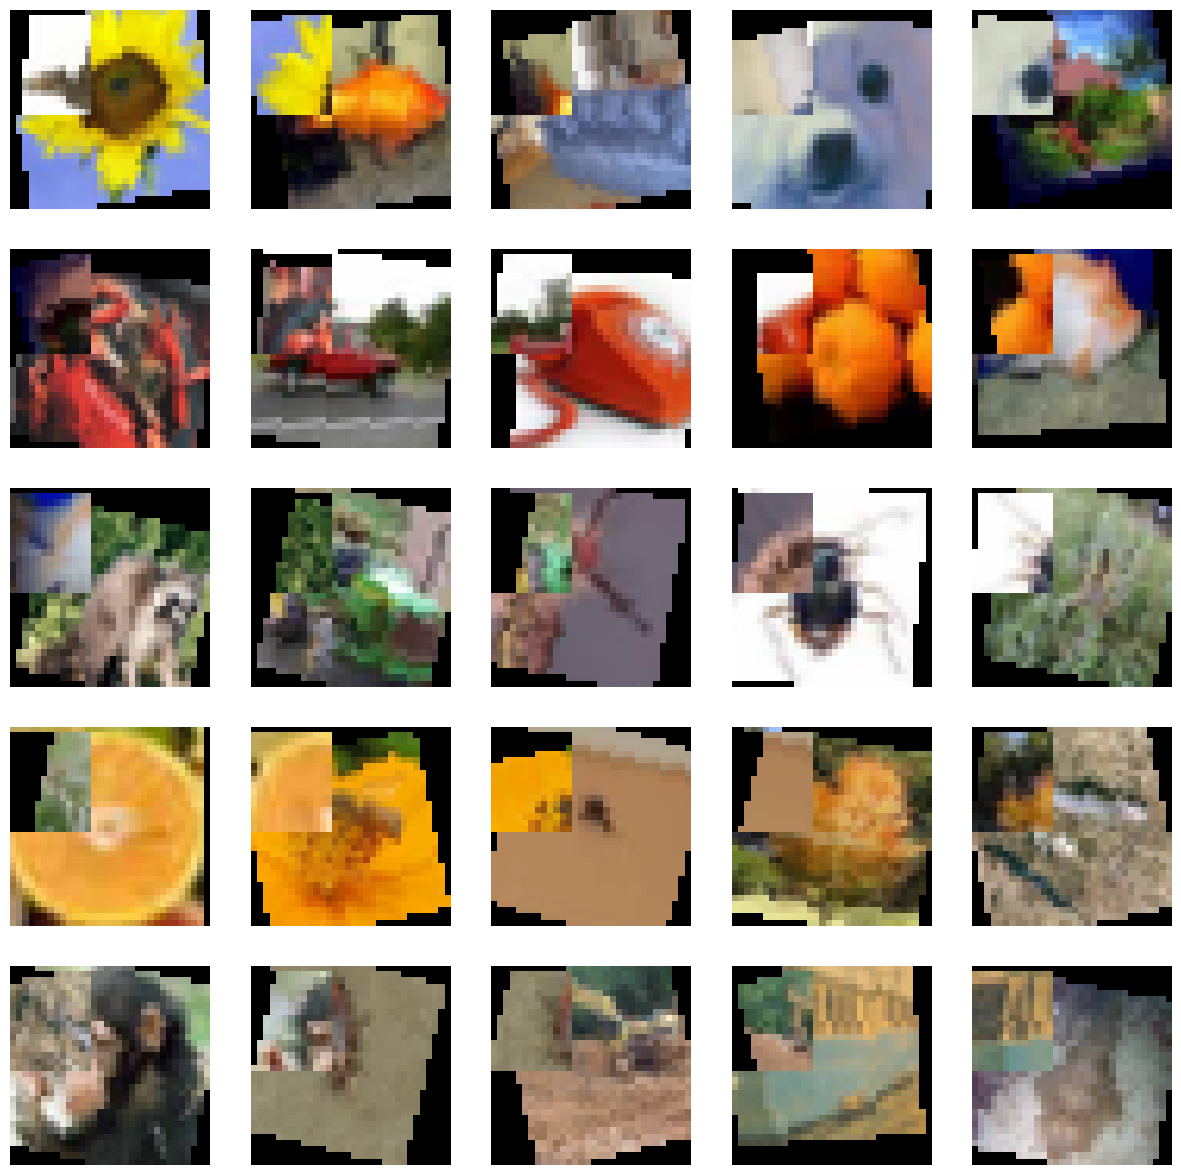

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 定义反归一化函数
def imshow(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # 反归一化
    img = np.clip(img, 0, 1)  # 确保图像在0-1范围内
    plt.imshow(img)

# 从trainloader中获取一个批次的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 确保获取到的图片数量足够
assert len(images) >= 25, "Batch size is less than 25, please increase the batch size."

# 创建5x5的图像网格
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    imshow(images[i], mean, std)
    plt.axis('off')

plt.show()


# Define the model

In [4]:
# --------------------- Use my implementation ------------------------
from torch import nn, optim
import resnet

model = resnet.resnet50()
dummy_input = torch.randn(4, 3, 32, 32)
output = model(dummy_input)
print(output.shape)


torch.Size([4, 100])


In [5]:
if torch.cuda.device_count() > 1:
    devices = [1,2,3,4]
    print(f"Using {len(devices)} GPUs")
    model = nn.DataParallel(model, device_ids=devices)

model = model.to(devices[0])

total_params = sum(p.numel() for p in model.parameters())
total_params_million = total_params / 10**6
print(f"Total parameters: {total_params_million:.2f}M")

Using 4 GPUs
Total parameters: 23.71M


# Train the model

In [6]:
# Training loop
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/ResNet')

def train_model(model, trainloader, criterion, optimizer, schedulers=[], num_epochs=10, val_every_iter=False, start_epoch=0):
    model.train()
    global_step = 0
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        train_loader = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)  # tqdm progress bar
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # Record LR
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('LR', current_lr, global_step)
            # Loss
            loss = criterion(outputs, labels)
            # Add to tensorboard
            writer.add_scalar('Loss/train', loss.item(), global_step)
            global_step += 1
            # Backward
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Update progress bar
            train_loader.set_postfix(loss=loss.item(), lr=current_lr)

            # Val every iteration
            if val_every_iter:
                val_loss, accuracy = evaluate_model(model, testloader, criterion)
                writer.add_scalar('Loss/val', val_loss, global_step)
                writer.add_scalar('Accuracy/val', accuracy, global_step)

        for scheduler in schedulers:
            scheduler.step()

        loss_epoch = running_loss / len(trainloader)
        if not val_every_iter:
            val_loss, accuracy = evaluate_model(model, testloader, criterion)
            writer.add_scalar('Loss/val', val_loss, global_step)
            writer.add_scalar('Accuracy/val', accuracy, global_step)
        # save model
        if (epoch+1) % 20 == 0:
            torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler1_state_dict': schedulers[0].state_dict(),
                    'epoch': epoch
                    }, f'weights/ResNet/epoch{epoch+1}.pth')
            print("*****************model saved*****************\n")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_epoch}")

    writer.close()

# Evaluate the model
def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        val_loss = 0
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, predicted_top5 = outputs.topk(5, dim=1, largest=True, sorted=True)
            temp = predicted_top5 == labels.view(-1, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            correct_top5 += temp.sum().item()

        accuracy = correct / total
        accuracy_top5 = correct_top5 / total
    print(f"Accuracy: {100 * accuracy:.2f}%, Accuracy(Top5): {100 * accuracy_top5:.2f}%")
    return val_loss/len(testloader), accuracy


# Warm up and decrease of LR
def lr_lambda(epoch):
    warmup_epochs = 30
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 0.1 ** ((epoch - warmup_epochs) / 150)



In [7]:
# Set the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
num_epochs = 200

if not os.path.exists('weights/ResNet'):
    os.makedirs('weights/ResNet')
torch.save({  # check how big the model is
            'model_state_dict': model.state_dict(),
            }, f'weights/ResNet/epoch{0}.pth')



In [8]:
# Load and train the model

# **********************
# checkpoint = torch.load('weights/ViT/epoch1.pth', map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler1_state_dict'])
# start_epoch = checkpoint['epoch'] + 1
#************************

train_model(model, trainloader, criterion, optimizer, schedulers = [scheduler], num_epochs=num_epochs, start_epoch=0)

Epoch 1/200: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it, loss=4.47, lr=3.33e-5]


Accuracy: 1.24%, Accuracy(Top5): 4.98%
Epoch 1/200, Loss: 4.582153367996216


Epoch 2/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=4.38, lr=6.67e-5]


Accuracy: 1.75%, Accuracy(Top5): 7.06%
Epoch 2/200, Loss: 4.4688273668289185


Epoch 3/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=4.13, lr=0.0001]


Accuracy: 6.49%, Accuracy(Top5): 21.67%
Epoch 3/200, Loss: 4.330959987640381


Epoch 4/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=4.08, lr=0.000133]


Accuracy: 9.66%, Accuracy(Top5): 28.65%
Epoch 4/200, Loss: 4.185251986980438


Epoch 5/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=4.25, lr=0.000167]


Accuracy: 11.74%, Accuracy(Top5): 32.92%
Epoch 5/200, Loss: 4.162471842765808


Epoch 6/200: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it, loss=3.98, lr=0.0002]


Accuracy: 13.61%, Accuracy(Top5): 36.23%
Epoch 6/200, Loss: 4.053734123706818


Epoch 7/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=4.1, lr=0.000233] 


Accuracy: 14.06%, Accuracy(Top5): 38.12%
Epoch 7/200, Loss: 3.877839171886444


Epoch 8/200: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it, loss=4.09, lr=0.000267]


Accuracy: 16.91%, Accuracy(Top5): 44.87%
Epoch 8/200, Loss: 3.910254716873169


Epoch 9/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=3.31, lr=0.0003]


Accuracy: 20.56%, Accuracy(Top5): 47.79%
Epoch 9/200, Loss: 3.8046045184135435


Epoch 10/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=3.64, lr=0.000333]


Accuracy: 24.82%, Accuracy(Top5): 53.09%
Epoch 10/200, Loss: 3.7711687088012695


Epoch 11/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=3.56, lr=0.000367]


Accuracy: 22.13%, Accuracy(Top5): 50.02%
Epoch 11/200, Loss: 3.637254571914673


Epoch 12/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=3.88, lr=0.0004]


Accuracy: 22.83%, Accuracy(Top5): 51.09%
Epoch 12/200, Loss: 3.6960209965705872


Epoch 13/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.78, lr=0.000433]


Accuracy: 25.78%, Accuracy(Top5): 54.91%
Epoch 13/200, Loss: 3.591369640827179


Epoch 14/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.84, lr=0.000467]


Accuracy: 27.07%, Accuracy(Top5): 56.72%
Epoch 14/200, Loss: 3.640027391910553


Epoch 15/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=3.88, lr=0.0005]


Accuracy: 30.16%, Accuracy(Top5): 60.00%
Epoch 15/200, Loss: 3.4456081986427307


Epoch 16/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=3.45, lr=0.000533]


Accuracy: 30.17%, Accuracy(Top5): 60.09%
Epoch 16/200, Loss: 3.396062707901001


Epoch 17/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=3.82, lr=0.000567]


Accuracy: 30.07%, Accuracy(Top5): 61.54%
Epoch 17/200, Loss: 3.288540780544281


Epoch 18/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.78, lr=0.0006]


Accuracy: 36.33%, Accuracy(Top5): 66.86%
Epoch 18/200, Loss: 3.399335241317749


Epoch 19/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.85, lr=0.000633]


Accuracy: 33.73%, Accuracy(Top5): 63.17%
Epoch 19/200, Loss: 3.1926564812660216


Epoch 20/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.53, lr=0.000667]


Accuracy: 37.62%, Accuracy(Top5): 69.34%
*****************model saved*****************

Epoch 20/200, Loss: 3.085719621181488


Epoch 21/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.62, lr=0.0007]


Accuracy: 37.03%, Accuracy(Top5): 67.14%
Epoch 21/200, Loss: 3.382948160171509


Epoch 22/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=3.13, lr=0.000733]


Accuracy: 38.93%, Accuracy(Top5): 69.70%
Epoch 22/200, Loss: 2.9813306391239167


Epoch 23/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.43, lr=0.000767]


Accuracy: 39.29%, Accuracy(Top5): 70.21%
Epoch 23/200, Loss: 3.254379689693451


Epoch 24/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=3.24, lr=0.0008]


Accuracy: 38.04%, Accuracy(Top5): 68.84%
Epoch 24/200, Loss: 3.160015273094177


Epoch 25/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=3.35, lr=0.000833]


Accuracy: 40.19%, Accuracy(Top5): 70.57%
Epoch 25/200, Loss: 3.0833009839057923


Epoch 26/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.33, lr=0.000867]


Accuracy: 43.37%, Accuracy(Top5): 74.56%
Epoch 26/200, Loss: 3.0557820558547975


Epoch 27/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.07, lr=0.0009]


Accuracy: 40.21%, Accuracy(Top5): 70.87%
Epoch 27/200, Loss: 3.0399662852287292


Epoch 28/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.32, lr=0.000933]


Accuracy: 44.80%, Accuracy(Top5): 74.35%
Epoch 28/200, Loss: 2.929448640346527


Epoch 29/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.2, lr=0.000967] 


Accuracy: 41.66%, Accuracy(Top5): 72.45%
Epoch 29/200, Loss: 3.0217671155929566


Epoch 30/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.92, lr=0.001]


Accuracy: 44.30%, Accuracy(Top5): 74.58%
Epoch 30/200, Loss: 3.0380997180938722


Epoch 31/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.89, lr=0.001]


Accuracy: 46.97%, Accuracy(Top5): 75.84%
Epoch 31/200, Loss: 2.7737330198287964


Epoch 32/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=3.27, lr=0.000985]


Accuracy: 42.11%, Accuracy(Top5): 73.22%
Epoch 32/200, Loss: 2.744440162181854


Epoch 33/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=3.04, lr=0.00097]


Accuracy: 48.12%, Accuracy(Top5): 77.49%
Epoch 33/200, Loss: 2.8079001009464264


Epoch 34/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.9, lr=0.000955] 


Accuracy: 50.45%, Accuracy(Top5): 79.11%
Epoch 34/200, Loss: 2.5402701139450072


Epoch 35/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.78, lr=0.00094]


Accuracy: 52.93%, Accuracy(Top5): 81.34%
Epoch 35/200, Loss: 2.7234429121017456


Epoch 36/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.17, lr=0.000926]


Accuracy: 49.76%, Accuracy(Top5): 80.06%
Epoch 36/200, Loss: 2.8744425415992736


Epoch 37/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.9, lr=0.000912] 


Accuracy: 54.92%, Accuracy(Top5): 81.76%
Epoch 37/200, Loss: 2.4940649807453155


Epoch 38/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.32, lr=0.000898]


Accuracy: 52.00%, Accuracy(Top5): 79.81%
Epoch 38/200, Loss: 2.6532026529312134


Epoch 39/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=3.01, lr=0.000884]


Accuracy: 55.15%, Accuracy(Top5): 82.26%
Epoch 39/200, Loss: 2.396738874912262


Epoch 40/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.33, lr=0.000871]


Accuracy: 53.83%, Accuracy(Top5): 81.36%
*****************model saved*****************

Epoch 40/200, Loss: 2.3764844834804535


Epoch 41/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.82, lr=0.000858]


Accuracy: 59.10%, Accuracy(Top5): 86.02%
Epoch 41/200, Loss: 2.4804497241973875


Epoch 42/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.49, lr=0.000845]


Accuracy: 54.33%, Accuracy(Top5): 82.61%
Epoch 42/200, Loss: 2.4075602412223818


Epoch 43/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.87, lr=0.000832]


Accuracy: 56.64%, Accuracy(Top5): 83.84%
Epoch 43/200, Loss: 2.4517705261707308


Epoch 44/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.29, lr=0.000819]


Accuracy: 59.14%, Accuracy(Top5): 84.81%
Epoch 44/200, Loss: 2.54982134103775


Epoch 45/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.11, lr=0.000807]


Accuracy: 60.48%, Accuracy(Top5): 86.15%
Epoch 45/200, Loss: 2.2912309646606444


Epoch 46/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.34, lr=0.000794]


Accuracy: 57.54%, Accuracy(Top5): 84.26%
Epoch 46/200, Loss: 2.305190682411194


Epoch 47/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.86, lr=0.000782]


Accuracy: 59.98%, Accuracy(Top5): 84.83%
Epoch 47/200, Loss: 2.512275439500809


Epoch 48/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.48, lr=0.00077] 


Accuracy: 60.66%, Accuracy(Top5): 85.82%
Epoch 48/200, Loss: 2.3848773539066315


Epoch 49/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.59, lr=0.000759]


Accuracy: 61.98%, Accuracy(Top5): 87.01%
Epoch 49/200, Loss: 2.193564349412918


Epoch 50/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.96, lr=0.000747]


Accuracy: 60.19%, Accuracy(Top5): 85.75%
Epoch 50/200, Loss: 2.1527067840099336


Epoch 51/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.52, lr=0.000736]


Accuracy: 57.46%, Accuracy(Top5): 83.83%
Epoch 51/200, Loss: 2.478411340713501


Epoch 52/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.12, lr=0.000724]


Accuracy: 58.40%, Accuracy(Top5): 84.61%
Epoch 52/200, Loss: 2.2575845301151274


Epoch 53/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.63, lr=0.000713]


Accuracy: 62.33%, Accuracy(Top5): 87.43%
Epoch 53/200, Loss: 2.4304928541183473


Epoch 54/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.96, lr=0.000703]


Accuracy: 61.73%, Accuracy(Top5): 86.70%
Epoch 54/200, Loss: 2.23113494515419


Epoch 55/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.58, lr=0.000692] 


Accuracy: 62.77%, Accuracy(Top5): 86.68%
Epoch 55/200, Loss: 2.197582021355629


Epoch 56/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.77, lr=0.000681]


Accuracy: 63.78%, Accuracy(Top5): 88.17%
Epoch 56/200, Loss: 2.1109811663627625


Epoch 57/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.64, lr=0.000671]


Accuracy: 64.71%, Accuracy(Top5): 87.86%
Epoch 57/200, Loss: 2.3226554155349732


Epoch 58/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.66, lr=0.000661]


Accuracy: 62.23%, Accuracy(Top5): 87.04%
Epoch 58/200, Loss: 2.210886514186859


Epoch 59/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.802, lr=0.000651]


Accuracy: 64.96%, Accuracy(Top5): 89.15%
Epoch 59/200, Loss: 1.8915882229804992


Epoch 60/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.899, lr=0.000641]


Accuracy: 64.57%, Accuracy(Top5): 88.24%
*****************model saved*****************

Epoch 60/200, Loss: 2.059354904294014


Epoch 61/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.33, lr=0.000631]


Accuracy: 64.10%, Accuracy(Top5): 88.02%
Epoch 61/200, Loss: 2.045384466648102


Epoch 62/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.88, lr=0.000621] 


Accuracy: 64.14%, Accuracy(Top5): 87.35%
Epoch 62/200, Loss: 1.9271139800548553


Epoch 63/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.56, lr=0.000612] 


Accuracy: 64.94%, Accuracy(Top5): 87.45%
Epoch 63/200, Loss: 1.7986203491687776


Epoch 64/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.22, lr=0.000603]


Accuracy: 64.58%, Accuracy(Top5): 87.85%
Epoch 64/200, Loss: 2.1250756859779356


Epoch 65/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.42, lr=0.000593]


Accuracy: 66.28%, Accuracy(Top5): 88.61%
Epoch 65/200, Loss: 2.124313420057297


Epoch 66/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.919, lr=0.000584]


Accuracy: 68.05%, Accuracy(Top5): 89.84%
Epoch 66/200, Loss: 1.7306784480810165


Epoch 67/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.5, lr=0.000575]  


Accuracy: 66.45%, Accuracy(Top5): 89.18%
Epoch 67/200, Loss: 2.0128800749778746


Epoch 68/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.57, lr=0.000567]


Accuracy: 66.56%, Accuracy(Top5): 88.68%
Epoch 68/200, Loss: 1.664353621006012


Epoch 69/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.54, lr=0.000558] 


Accuracy: 65.84%, Accuracy(Top5): 88.43%
Epoch 69/200, Loss: 1.8569525092840196


Epoch 70/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.43, lr=0.00055] 


Accuracy: 67.38%, Accuracy(Top5): 89.14%
Epoch 70/200, Loss: 2.033458212018013


Epoch 71/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.25, lr=0.000541] 


Accuracy: 65.64%, Accuracy(Top5): 88.95%
Epoch 71/200, Loss: 2.0670985698699953


Epoch 72/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.53, lr=0.000533]


Accuracy: 67.32%, Accuracy(Top5): 89.54%
Epoch 72/200, Loss: 1.9988402009010315


Epoch 73/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.77, lr=0.000525] 


Accuracy: 66.50%, Accuracy(Top5): 88.78%
Epoch 73/200, Loss: 1.844375815987587


Epoch 74/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.32, lr=0.000517] 


Accuracy: 65.19%, Accuracy(Top5): 88.12%
Epoch 74/200, Loss: 1.9059786379337311


Epoch 75/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.36, lr=0.000509]


Accuracy: 67.93%, Accuracy(Top5): 89.37%
Epoch 75/200, Loss: 2.0070236012339593


Epoch 76/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.48, lr=0.000501] 


Accuracy: 67.82%, Accuracy(Top5): 89.42%
Epoch 76/200, Loss: 1.837462630867958


Epoch 77/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.29, lr=0.000494] 


Accuracy: 68.52%, Accuracy(Top5): 89.59%
Epoch 77/200, Loss: 1.8609640955924989


Epoch 78/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.43, lr=0.000486] 


Accuracy: 67.16%, Accuracy(Top5): 89.11%
Epoch 78/200, Loss: 1.9811586350202561


Epoch 79/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.36, lr=0.000479]


Accuracy: 66.46%, Accuracy(Top5): 88.95%
Epoch 79/200, Loss: 1.9905220687389373


Epoch 80/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.08, lr=0.000471] 


Accuracy: 68.53%, Accuracy(Top5): 90.10%
*****************model saved*****************

Epoch 80/200, Loss: 1.6287763580679893


Epoch 81/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.91, lr=0.000464] 


Accuracy: 66.85%, Accuracy(Top5): 88.93%
Epoch 81/200, Loss: 1.7318865299224853


Epoch 82/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.89, lr=0.000457]


Accuracy: 67.96%, Accuracy(Top5): 89.19%
Epoch 82/200, Loss: 1.6602196261286735


Epoch 83/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.16, lr=0.00045] 


Accuracy: 67.76%, Accuracy(Top5): 88.86%
Epoch 83/200, Loss: 1.917643678188324


Epoch 84/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.455, lr=0.000443]


Accuracy: 68.11%, Accuracy(Top5): 89.21%
Epoch 84/200, Loss: 1.7033182874321937


Epoch 85/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.11, lr=0.000437]


Accuracy: 69.28%, Accuracy(Top5): 90.10%
Epoch 85/200, Loss: 1.6962659657001495


Epoch 86/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.24, lr=0.00043] 


Accuracy: 68.20%, Accuracy(Top5): 89.60%
Epoch 86/200, Loss: 1.701314425468445


Epoch 87/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.03, lr=0.000423]


Accuracy: 68.51%, Accuracy(Top5): 89.44%
Epoch 87/200, Loss: 1.8543239772319793


Epoch 88/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.22, lr=0.000417]


Accuracy: 69.44%, Accuracy(Top5): 90.16%
Epoch 88/200, Loss: 1.760332553088665


Epoch 89/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.44, lr=0.000411] 


Accuracy: 67.20%, Accuracy(Top5): 88.84%
Epoch 89/200, Loss: 1.6341632440686227


Epoch 90/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.65, lr=0.000404] 


Accuracy: 67.11%, Accuracy(Top5): 88.88%
Epoch 90/200, Loss: 1.85080885887146


Epoch 91/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.19, lr=0.000398] 


Accuracy: 69.03%, Accuracy(Top5): 89.65%
Epoch 91/200, Loss: 1.6634428277611732


Epoch 92/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.65, lr=0.000392] 


Accuracy: 66.62%, Accuracy(Top5): 88.14%
Epoch 92/200, Loss: 1.8117280200123786


Epoch 93/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.43, lr=0.000386] 


Accuracy: 69.04%, Accuracy(Top5): 89.41%
Epoch 93/200, Loss: 1.6222724556922912


Epoch 94/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.96, lr=0.00038]


Accuracy: 68.81%, Accuracy(Top5): 89.71%
Epoch 94/200, Loss: 1.8707910656929017


Epoch 95/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.616, lr=0.000374]


Accuracy: 69.85%, Accuracy(Top5): 90.20%
Epoch 95/200, Loss: 1.7536655902862548


Epoch 96/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.06, lr=0.000369] 


Accuracy: 68.57%, Accuracy(Top5): 89.39%
Epoch 96/200, Loss: 1.7743215382099151


Epoch 97/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.61, lr=0.000363] 


Accuracy: 68.40%, Accuracy(Top5): 89.26%
Epoch 97/200, Loss: 1.6400196403265


Epoch 98/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.01, lr=0.000358] 


Accuracy: 70.01%, Accuracy(Top5): 90.35%
Epoch 98/200, Loss: 1.5494193404912948


Epoch 99/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.95, lr=0.000352] 


Accuracy: 68.84%, Accuracy(Top5): 89.58%
Epoch 99/200, Loss: 1.5103761747479438


Epoch 100/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.95, lr=0.000347] 


Accuracy: 69.43%, Accuracy(Top5): 89.80%
*****************model saved*****************

Epoch 100/200, Loss: 1.5403535425662995


Epoch 101/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.39, lr=0.000341] 


Accuracy: 69.64%, Accuracy(Top5): 89.87%
Epoch 101/200, Loss: 1.50528334826231


Epoch 102/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.15, lr=0.000336]


Accuracy: 69.58%, Accuracy(Top5): 89.84%
Epoch 102/200, Loss: 1.6965164840221405


Epoch 103/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.3, lr=0.000331]  


Accuracy: 69.22%, Accuracy(Top5): 89.92%
Epoch 103/200, Loss: 1.6565109118819237


Epoch 104/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.42, lr=0.000326] 


Accuracy: 69.31%, Accuracy(Top5): 89.89%
Epoch 104/200, Loss: 1.500833234190941


Epoch 105/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.14, lr=0.000321] 


Accuracy: 70.00%, Accuracy(Top5): 90.11%
Epoch 105/200, Loss: 1.5031294718384742


Epoch 106/200: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it, loss=1.28, lr=0.000316]


Accuracy: 68.68%, Accuracy(Top5): 88.90%
Epoch 106/200, Loss: 1.6717599779367447


Epoch 107/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.12, lr=0.000311] 


Accuracy: 70.20%, Accuracy(Top5): 90.30%
Epoch 107/200, Loss: 1.5206394478678704


Epoch 108/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.71, lr=0.000307] 


Accuracy: 70.71%, Accuracy(Top5): 90.46%
Epoch 108/200, Loss: 1.6317030310630798


Epoch 109/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.986, lr=0.000302]


Accuracy: 69.60%, Accuracy(Top5): 89.86%
Epoch 109/200, Loss: 1.682708540558815


Epoch 110/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.73, lr=0.000297] 


Accuracy: 69.04%, Accuracy(Top5): 89.83%
Epoch 110/200, Loss: 1.6177291840314865


Epoch 111/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.78, lr=0.000293]


Accuracy: 70.50%, Accuracy(Top5): 90.23%
Epoch 111/200, Loss: 1.76233069896698


Epoch 112/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.713, lr=0.000288]


Accuracy: 71.20%, Accuracy(Top5): 90.48%
Epoch 112/200, Loss: 1.618417453765869


Epoch 113/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=2.08, lr=0.000284] 


Accuracy: 70.71%, Accuracy(Top5): 90.16%
Epoch 113/200, Loss: 1.535363383591175


Epoch 114/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.786, lr=0.00028]


Accuracy: 70.51%, Accuracy(Top5): 90.66%
Epoch 114/200, Loss: 1.4286441400647163


Epoch 115/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.77, lr=0.000275]


Accuracy: 70.95%, Accuracy(Top5): 90.11%
Epoch 115/200, Loss: 1.59743262976408


Epoch 116/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.85, lr=0.000271] 


Accuracy: 69.70%, Accuracy(Top5): 89.31%
Epoch 116/200, Loss: 1.511389110982418


Epoch 117/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.31, lr=0.000267] 


Accuracy: 70.47%, Accuracy(Top5): 90.20%
Epoch 117/200, Loss: 1.4699427537620067


Epoch 118/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.01, lr=0.000263] 


Accuracy: 69.69%, Accuracy(Top5): 89.49%
Epoch 118/200, Loss: 1.637678599357605


Epoch 119/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.88, lr=0.000259]


Accuracy: 70.16%, Accuracy(Top5): 89.78%
Epoch 119/200, Loss: 1.6828332364559173


Epoch 120/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.9, lr=0.000255]  


Accuracy: 71.02%, Accuracy(Top5): 90.60%
*****************model saved*****************

Epoch 120/200, Loss: 1.4168826937675476


Epoch 121/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.63, lr=0.000251] 


Accuracy: 71.13%, Accuracy(Top5): 90.47%
Epoch 121/200, Loss: 1.3286433778703213


Epoch 122/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.25, lr=0.000247] 


Accuracy: 70.67%, Accuracy(Top5): 90.08%
Epoch 122/200, Loss: 1.4091511100530625


Epoch 123/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.97, lr=0.000244] 


Accuracy: 70.44%, Accuracy(Top5): 90.19%
Epoch 123/200, Loss: 1.6310385704040526


Epoch 124/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=2.1, lr=0.00024]  


Accuracy: 69.71%, Accuracy(Top5): 89.44%
Epoch 124/200, Loss: 1.474793229997158


Epoch 125/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.94, lr=0.000236] 


Accuracy: 70.38%, Accuracy(Top5): 89.96%
Epoch 125/200, Loss: 1.520552884042263


Epoch 126/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2.02, lr=0.000233] 


Accuracy: 70.96%, Accuracy(Top5): 89.90%
Epoch 126/200, Loss: 1.6312907814979554


Epoch 127/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.68, lr=0.000229] 


Accuracy: 70.80%, Accuracy(Top5): 90.29%
Epoch 127/200, Loss: 1.3741820100694895


Epoch 128/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=0.244, lr=0.000226]


Accuracy: 71.94%, Accuracy(Top5): 90.67%
Epoch 128/200, Loss: 1.0328357361257077


Epoch 129/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.52, lr=0.000222] 


Accuracy: 70.45%, Accuracy(Top5): 90.14%
Epoch 129/200, Loss: 1.3915649592876433


Epoch 130/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.72, lr=0.000219] 


Accuracy: 72.25%, Accuracy(Top5): 90.91%
Epoch 130/200, Loss: 1.5297992773354054


Epoch 131/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.91, lr=0.000215] 


Accuracy: 71.70%, Accuracy(Top5): 90.85%
Epoch 131/200, Loss: 1.2028692282736302


Epoch 132/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.231, lr=0.000212]


Accuracy: 71.02%, Accuracy(Top5): 90.20%
Epoch 132/200, Loss: 1.2916515924036502


Epoch 133/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.56, lr=0.000209] 


Accuracy: 71.23%, Accuracy(Top5): 90.81%
Epoch 133/200, Loss: 1.626118166744709


Epoch 134/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.96, lr=0.000206] 


Accuracy: 71.36%, Accuracy(Top5): 90.56%
Epoch 134/200, Loss: 1.3565022855997086


Epoch 135/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.37, lr=0.000203] 


Accuracy: 71.13%, Accuracy(Top5): 90.71%
Epoch 135/200, Loss: 1.4320561107248069


Epoch 136/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.609, lr=0.0002]


Accuracy: 71.20%, Accuracy(Top5): 90.52%
Epoch 136/200, Loss: 1.4982993125915527


Epoch 137/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=0.94, lr=0.000196]


Accuracy: 70.97%, Accuracy(Top5): 90.20%
Epoch 137/200, Loss: 1.6384380877017974


Epoch 138/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.59, lr=0.000193]


Accuracy: 71.65%, Accuracy(Top5): 90.41%
Epoch 138/200, Loss: 1.3788355827331542


Epoch 139/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.89, lr=0.000191] 


Accuracy: 71.33%, Accuracy(Top5): 90.38%
Epoch 139/200, Loss: 1.4671054780483246


Epoch 140/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.91, lr=0.000188] 


Accuracy: 70.57%, Accuracy(Top5): 89.99%
*****************model saved*****************

Epoch 140/200, Loss: 1.3814869672060013


Epoch 141/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.78, lr=0.000185] 


Accuracy: 71.23%, Accuracy(Top5): 89.92%
Epoch 141/200, Loss: 1.4015131697058678


Epoch 142/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.85, lr=0.000182] 


Accuracy: 71.27%, Accuracy(Top5): 90.28%
Epoch 142/200, Loss: 1.3418348759412766


Epoch 143/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.13, lr=0.000179]


Accuracy: 71.60%, Accuracy(Top5): 90.18%
Epoch 143/200, Loss: 1.41506387591362


Epoch 144/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.62, lr=0.000176] 


Accuracy: 71.01%, Accuracy(Top5): 89.44%
Epoch 144/200, Loss: 1.1108338095247745


Epoch 145/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.44, lr=0.000174] 


Accuracy: 72.33%, Accuracy(Top5): 90.44%
Epoch 145/200, Loss: 1.4494006410241127


Epoch 146/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.46, lr=0.000171] 


Accuracy: 72.61%, Accuracy(Top5): 90.87%
Epoch 146/200, Loss: 1.3171209506690502


Epoch 147/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.65, lr=0.000169] 


Accuracy: 72.16%, Accuracy(Top5): 91.03%
Epoch 147/200, Loss: 1.420480528473854


Epoch 148/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.76, lr=0.000166] 


Accuracy: 70.86%, Accuracy(Top5): 89.90%
Epoch 148/200, Loss: 1.1459620863199234


Epoch 149/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.69, lr=0.000163] 


Accuracy: 71.68%, Accuracy(Top5): 90.49%
Epoch 149/200, Loss: 1.4240498065948486


Epoch 150/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.13, lr=0.000161] 


Accuracy: 71.60%, Accuracy(Top5): 90.14%
Epoch 150/200, Loss: 1.1416269093751907


Epoch 151/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=2.03, lr=0.000158] 


Accuracy: 72.69%, Accuracy(Top5): 90.36%
Epoch 151/200, Loss: 1.3120597943663597


Epoch 152/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.59, lr=0.000156] 


Accuracy: 72.51%, Accuracy(Top5): 90.71%
Epoch 152/200, Loss: 1.4510507851839065


Epoch 153/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.76, lr=0.000154] 


Accuracy: 72.50%, Accuracy(Top5): 91.04%
Epoch 153/200, Loss: 1.0459049724042415


Epoch 154/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.67, lr=0.000151]  


Accuracy: 71.98%, Accuracy(Top5): 90.46%
Epoch 154/200, Loss: 1.3657052610069513


Epoch 155/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.44, lr=0.000149] 


Accuracy: 71.63%, Accuracy(Top5): 90.36%
Epoch 155/200, Loss: 1.3904353074729443


Epoch 156/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.397, lr=0.000147]


Accuracy: 71.93%, Accuracy(Top5): 90.56%
Epoch 156/200, Loss: 1.2511904634535314


Epoch 157/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.24, lr=0.000145] 


Accuracy: 72.51%, Accuracy(Top5): 90.47%
Epoch 157/200, Loss: 1.234490169212222


Epoch 158/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.17, lr=0.000142] 


Accuracy: 72.55%, Accuracy(Top5): 90.91%
Epoch 158/200, Loss: 1.36497171074152


Epoch 159/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.827, lr=0.00014] 


Accuracy: 72.64%, Accuracy(Top5): 90.83%
Epoch 159/200, Loss: 1.4265455272048713


Epoch 160/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.23, lr=0.000138] 


Accuracy: 71.96%, Accuracy(Top5): 90.63%
*****************model saved*****************

Epoch 160/200, Loss: 1.3523079216480256


Epoch 161/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=2, lr=0.000136]    


Accuracy: 71.99%, Accuracy(Top5): 90.43%
Epoch 161/200, Loss: 1.191156303882599


Epoch 162/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.96, lr=0.000134] 


Accuracy: 72.31%, Accuracy(Top5): 90.30%
Epoch 162/200, Loss: 1.2963500417768956


Epoch 163/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.58, lr=0.000132] 


Accuracy: 71.46%, Accuracy(Top5): 90.37%
Epoch 163/200, Loss: 1.4803149446845054


Epoch 164/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.528, lr=0.00013]


Accuracy: 72.24%, Accuracy(Top5): 90.86%
Epoch 164/200, Loss: 1.1670312516391277


Epoch 165/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.44, lr=0.000128]  


Accuracy: 72.88%, Accuracy(Top5): 90.95%
Epoch 165/200, Loss: 1.034257167764008


Epoch 166/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.47, lr=0.000126] 


Accuracy: 72.38%, Accuracy(Top5): 90.81%
Epoch 166/200, Loss: 1.3545107007026673


Epoch 167/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.34, lr=0.000124] 


Accuracy: 72.89%, Accuracy(Top5): 91.07%
Epoch 167/200, Loss: 1.390729857981205


Epoch 168/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.64, lr=0.000122] 


Accuracy: 72.42%, Accuracy(Top5): 90.77%
Epoch 168/200, Loss: 1.433095607161522


Epoch 169/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.47, lr=0.00012] 


Accuracy: 71.92%, Accuracy(Top5): 90.97%
Epoch 169/200, Loss: 1.5091096103191375


Epoch 170/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.35, lr=0.000118] 


Accuracy: 72.23%, Accuracy(Top5): 90.48%
Epoch 170/200, Loss: 1.2553022503852844


Epoch 171/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.32, lr=0.000117] 


Accuracy: 71.76%, Accuracy(Top5): 90.57%
Epoch 171/200, Loss: 1.2951974466443061


Epoch 172/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.7, lr=0.000115]  


Accuracy: 72.54%, Accuracy(Top5): 91.01%
Epoch 172/200, Loss: 1.2560632646083831


Epoch 173/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.21, lr=0.000113] 


Accuracy: 72.02%, Accuracy(Top5): 90.76%
Epoch 173/200, Loss: 1.3369391873478889


Epoch 174/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.65, lr=0.000111] 


Accuracy: 72.64%, Accuracy(Top5): 90.70%
Epoch 174/200, Loss: 1.3910842522978784


Epoch 175/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=0.892, lr=0.00011]


Accuracy: 73.03%, Accuracy(Top5): 90.92%
Epoch 175/200, Loss: 1.2875730991363525


Epoch 176/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.63, lr=0.000108] 


Accuracy: 71.55%, Accuracy(Top5): 90.45%
Epoch 176/200, Loss: 1.2286128252744675


Epoch 177/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.19, lr=0.000106] 


Accuracy: 72.52%, Accuracy(Top5): 91.03%
Epoch 177/200, Loss: 1.1390323750674725


Epoch 178/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.6, lr=0.000105]  


Accuracy: 72.66%, Accuracy(Top5): 90.88%
Epoch 178/200, Loss: 1.2029323674738408


Epoch 179/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.19, lr=0.000103] 


Accuracy: 72.94%, Accuracy(Top5): 91.13%
Epoch 179/200, Loss: 1.2007524413987993


Epoch 180/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.62, lr=0.000102] 


Accuracy: 72.34%, Accuracy(Top5): 90.96%
*****************model saved*****************

Epoch 180/200, Loss: 1.2496191836893558


Epoch 181/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.11, lr=0.0001] 


Accuracy: 72.33%, Accuracy(Top5): 90.74%
Epoch 181/200, Loss: 1.2183587282896042


Epoch 182/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.2, lr=9.85e-5]  


Accuracy: 72.84%, Accuracy(Top5): 90.93%
Epoch 182/200, Loss: 1.2340264707803725


Epoch 183/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=1.12, lr=9.7e-5] 


Accuracy: 71.53%, Accuracy(Top5): 90.69%
Epoch 183/200, Loss: 1.1565944261848926


Epoch 184/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.18, lr=9.55e-5]  


Accuracy: 72.83%, Accuracy(Top5): 91.12%
Epoch 184/200, Loss: 1.166786722652614


Epoch 185/200: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it, loss=1.59, lr=9.4e-5] 


Accuracy: 72.50%, Accuracy(Top5): 90.85%
Epoch 185/200, Loss: 1.3990581654012204


Epoch 186/200: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it, loss=1.21, lr=9.26e-5] 


Accuracy: 72.54%, Accuracy(Top5): 90.58%
Epoch 186/200, Loss: 1.1944621086120606


Epoch 187/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.91, lr=9.12e-5] 


Accuracy: 72.37%, Accuracy(Top5): 90.86%
Epoch 187/200, Loss: 1.1681544087827205


Epoch 188/200: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it, loss=0.982, lr=8.98e-5]


Accuracy: 72.51%, Accuracy(Top5): 90.77%
Epoch 188/200, Loss: 1.2658453159034253


Epoch 189/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.35, lr=8.84e-5] 


Accuracy: 73.19%, Accuracy(Top5): 90.80%
Epoch 189/200, Loss: 1.1479321574792265


Epoch 190/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.453, lr=8.71e-5]


Accuracy: 72.88%, Accuracy(Top5): 91.02%
Epoch 190/200, Loss: 1.244476744532585


Epoch 191/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.47, lr=8.58e-5] 


Accuracy: 72.63%, Accuracy(Top5): 90.82%
Epoch 191/200, Loss: 1.2573869161307811


Epoch 192/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=0.6, lr=8.45e-5]   


Accuracy: 72.28%, Accuracy(Top5): 90.94%
Epoch 192/200, Loss: 1.1280415393412113


Epoch 193/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=0.688, lr=8.32e-5]


Accuracy: 72.58%, Accuracy(Top5): 90.73%
Epoch 193/200, Loss: 1.139607374370098


Epoch 194/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.75, lr=8.19e-5] 


Accuracy: 73.16%, Accuracy(Top5): 90.96%
Epoch 194/200, Loss: 1.2278170213103294


Epoch 195/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=0.92, lr=8.07e-5] 


Accuracy: 72.95%, Accuracy(Top5): 90.84%
Epoch 195/200, Loss: 1.1525733679533006


Epoch 196/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=0.781, lr=7.94e-5] 


Accuracy: 73.20%, Accuracy(Top5): 90.78%
Epoch 196/200, Loss: 1.1257361941039563


Epoch 197/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.35, lr=7.82e-5]


Accuracy: 72.91%, Accuracy(Top5): 90.85%
Epoch 197/200, Loss: 1.362950323522091


Epoch 198/200: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it, loss=1.47, lr=7.7e-5] 


Accuracy: 72.70%, Accuracy(Top5): 90.81%
Epoch 198/200, Loss: 1.2365116775035858


Epoch 199/200: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it, loss=1.6, lr=7.59e-5]  


Accuracy: 72.68%, Accuracy(Top5): 91.07%
Epoch 199/200, Loss: 1.0681613951921463


Epoch 200/200: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it, loss=1.25, lr=7.47e-5] 


Accuracy: 72.74%, Accuracy(Top5): 90.91%
*****************model saved*****************

Epoch 200/200, Loss: 1.1590904667973518
